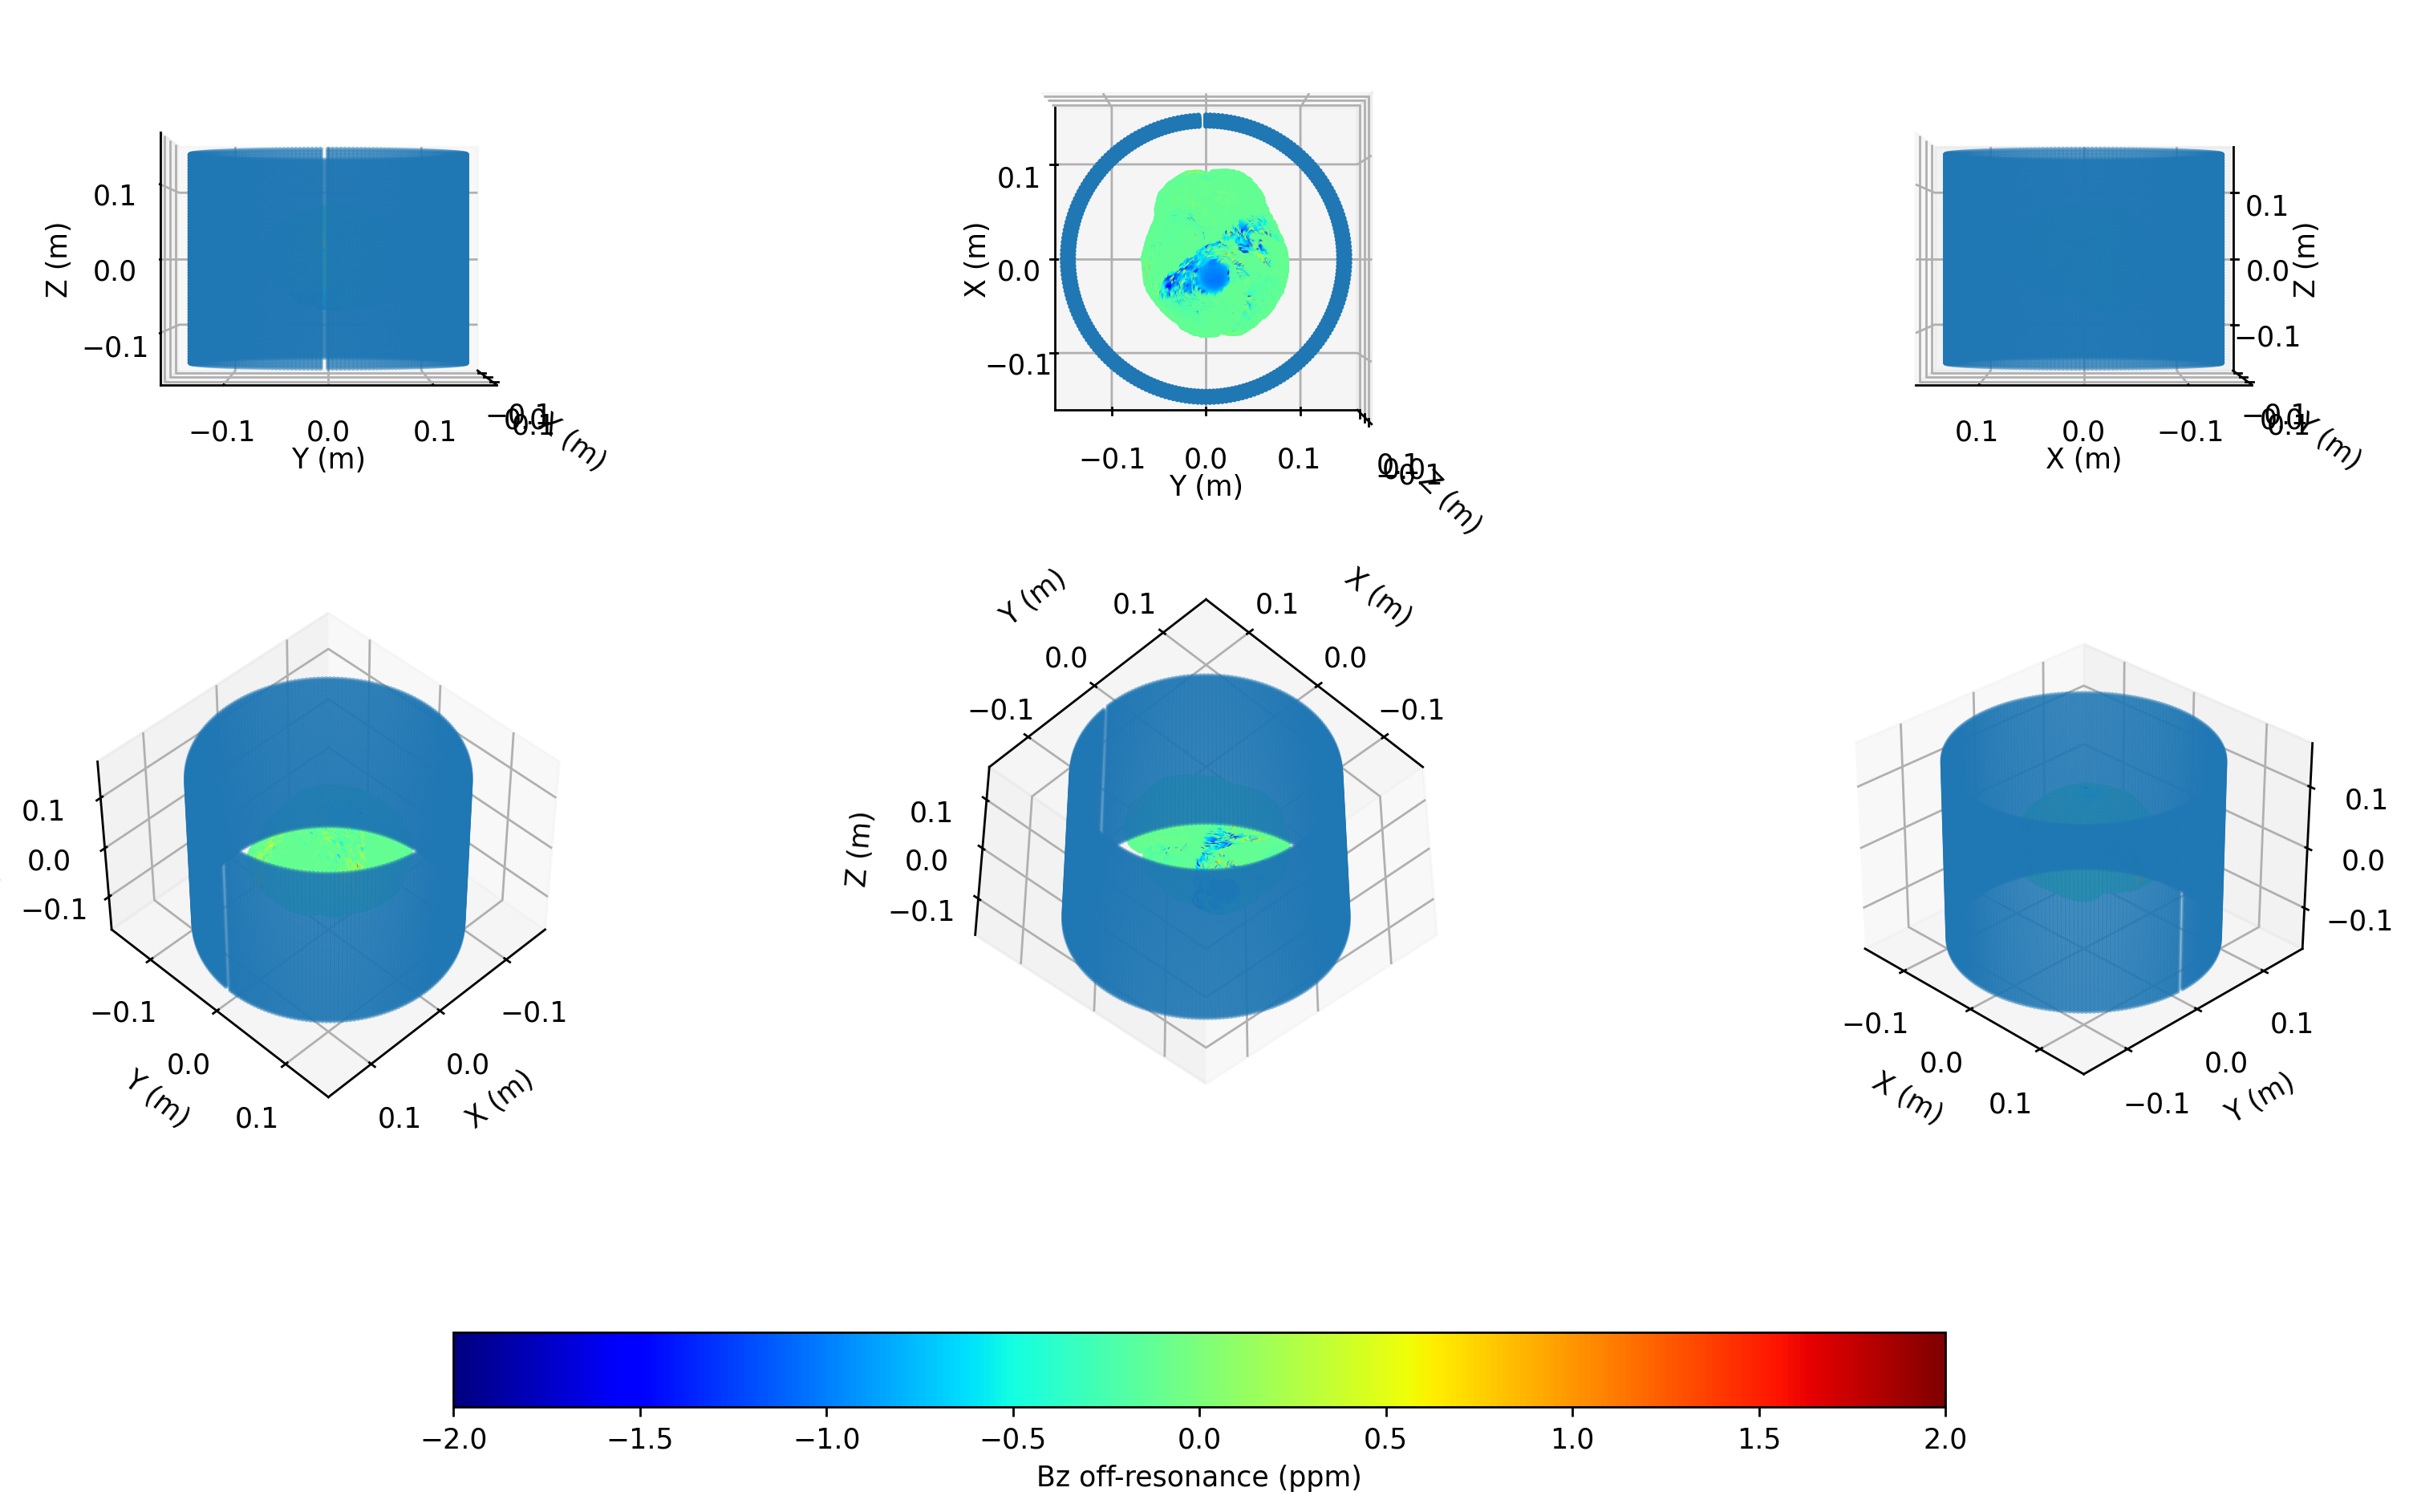

In [ ]:
from scipy.linalg import lstsq
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
import matplotlib as mpl
# 圆柱尺寸参数(单位：m)
a = 0.14  # 圆柱半径
L = 0.3  # 圆柱高度
h_phi = 0.004  # 方位角步长
h_z = 0.004   # 高度步长
N_phi = int(2 * np.pi * a / h_phi)  # 方位角方向的网格数量
Nz = int(L / h_z)  # 高度方向的网格数量
N = N_phi * Nz
mu_0 = 4 * np.pi * 1e-7

# 生成源点的网格点坐标
grid_points = []
for n in range(1, N_phi * Nz + 1):
    # 计算 alpha 和 beta
    alpha = (n - 1) % N_phi
    beta = (n - alpha - 1) // N_phi + 1
    
    # 计算源点坐标
    x_n = a * np.cos(alpha * h_phi / a)
    y_n = a * np.sin(alpha * h_phi / a)
    z_n = -L / 2 + (2 * beta - 1) / 2 * h_z
    
    # 将坐标添加到网格点列表
    grid_points.append((x_n, y_n, z_n))

# 转换为 numpy 数组
grid_points = np.array(grid_points) 
# 获取圆柱表面上网格点的坐标
x_coords = grid_points[:, 0]
y_coords = grid_points[:, 1]
z_coords = grid_points[:, 2]

# 假设目标磁场 b_k (ΔB0)，从你的 fieldmap 中提取目标磁场数据
# 假设 b_target 是一个包含目标点坐标和磁场强度的3D fieldmap
# n = 1
B0_map = sio.loadmat("B0_map_valid.mat")
b_k = B0_map['B0_data'].flatten() * 5 / 1e6
x_k = B0_map['X'].flatten()
y_k = B0_map['Y'].flatten()
z_k = B0_map['Z'].flatten()
# x_k = x_k[::n]
# y_k = y_k[::n]
# z_k = z_k[::n]
# b_k = b_k[::n] * 5 / 1e6 
fig = plt.figure(dpi=250, figsize=(16, 10))
for idx, (elev, azim) in enumerate([(0, 0), (-90, 0), (0, 90), (45, 45), (-45, 45), (30, -45)]):
    ax = fig.add_subplot(2, 3, idx + 1, projection='3d')
    # 绘制电流源网格点
    ax.scatter(x_coords, y_coords, z_coords, s=1, marker='o', alpha=0.5, label="Current Sources")
    # 绘制目标磁场点并设置颜色
    ax.scatter(x_k, y_k, z_k, s=1, c=b_k, cmap='jet', marker='o', alpha=0.8, label="Target B Field")
    ax.view_init(elev=elev, azim=azim) 
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-2, vmax=2), cmap='jet'),
             ax=fig.axes, orientation='horizontal', label='Bz off-resonance (ppm)', shrink=0.6)

# 计算 r+ 和 r- 的函数
def compute_r_plus_minus(x_k, y_k, z_k, x_n, y_n, z_n, h_z):
    """计算r_+ 和 r_-"""
    r_plus = np.sqrt((x_k - x_n)**2 + (y_k - y_n)**2 + (z_k - (z_n + h_z / 2))**2)
    r_minus = np.sqrt((x_k - x_n)**2 + (y_k - y_n)**2 + (z_k - (z_n - h_z / 2))**2)
    return r_plus, r_minus

# 计算 c_{k,n} 的函数
def compute_c_k_n(x_k, y_k, z_k, x_n, y_n, z_n, h_phi, h_z, a):
    """计算c_{k,n}的值"""
    r_plus, r_minus = compute_r_plus_minus(x_k, y_k, z_k, x_n, y_n, z_n, h_z)
    c_k_n = (mu_0 / (4 * np.pi * a)) * (x_n * x_k + y_n * y_k - a**2) * (1 / r_minus**3 - 1 / r_plus**3) * h_phi
    return c_k_n

# 计算目标磁场的总和
def compute_field_matrix(x_k, y_k, z_k, grid_points, N, h_phi, h_z, a):
    """计算磁场矩阵C"""
    C = np.zeros((x_k.size, len(grid_points)))
    for i in range(x_k.size):
        for n in range(len(grid_points)):
            x_n, y_n, z_n = grid_points[n]
            C[i, n] = compute_c_k_n(x_k[i], y_k[i], z_k[i], x_n, y_n, z_n, h_phi, h_z, a)
    return C
C = compute_field_matrix(x_k.flatten(), y_k.flatten(), z_k.flatten(), grid_points, len(grid_points), h_phi, h_z, a)
# N = len(grid_points)  # 电流源的数量
# psi_n = np.ones(len(grid_points)) 

# def error_function(psi_n, C, b_k):
#     """计算目标场与计算场之间的二次误差"""
#     b_computed = np.dot(C, psi_n)  # 计算磁场
#     error = np.linalg.norm(b_k - b_computed)**2  # 计算二次误差
#     return error
# # 使用最小化函数优化电流强度 psi_n
# result = minimize(error_function, psi_n, args=(C, b_k), 
#                   method='L-BFGS-B', options={'disp': True, 'maxiter': 100})

# # 优化后的电流强度
# optimized_psi_n = result.x
# print(optimized_psi_n)

psi_n, _, _, _ = lstsq(C, b_k)

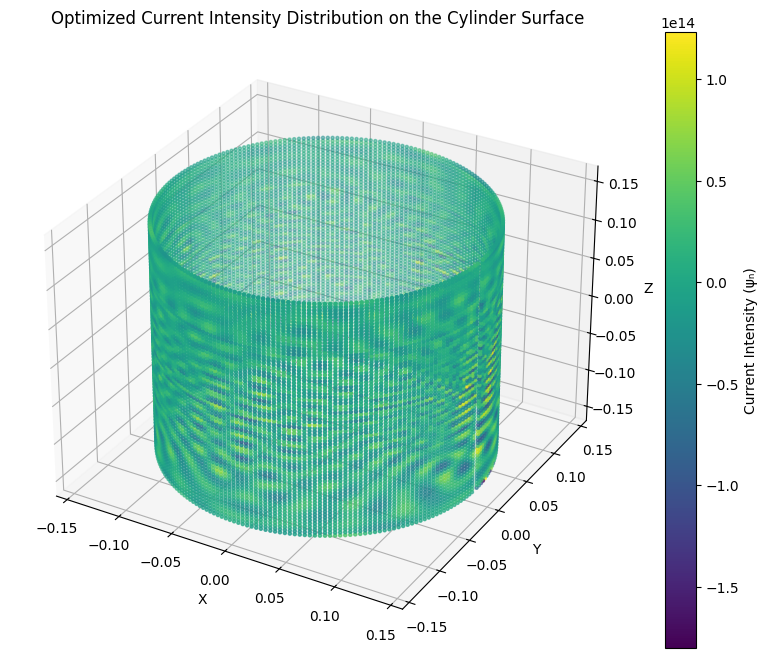

In [3]:
optimized_psi_n = psi_n
# 获取圆柱表面上网格点的坐标
x_coords = grid_points[:, 0]
y_coords = grid_points[:, 1]
z_coords = grid_points[:, 2]

# 可视化：使用 3D 图绘制电流强度在圆柱表面上的分布
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图：每个点的大小或颜色由电流强度决定
sc = ax.scatter(x_coords, y_coords, z_coords, c=optimized_psi_n, s=5, marker='o', cmap='viridis')

# 设置图表标题和标签
ax.set_title("Optimized Current Intensity Distribution on the Cylinder Surface")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# 添加颜色条，表示电流强度的范围
fig.colorbar(sc, label="Current Intensity (ψₙ)")

# # 如果需要显示每个点的电流强度值，可以通过 `ax.text()` 添加
# for i in range(len(grid_points)):
#     ax.text(x_coords[i], y_coords[i], z_coords[i], f'{optimized_psi_n[i]:.2f}', color='black', fontsize=8)

plt.show()

In [4]:
from scipy.linalg import circulant
t = 1.4e-3 # thickness
kappa = 5.96e7 # electric conductivity

w_col = np.zeros(N_phi)
w_col[0] = 4
w_col[1] = -1
w_col[-1] = -1
W = circulant(w_col)
I_phi = np.eye(N_phi)  # N_phi x N_phi 单位矩阵
Zero = np.zeros((N_phi, N_phi))  # N_phi x N_phi 零矩阵
# 构造 block Toeplitz 结构
blocks = []
for i in range(Nz):
    row = []
    for j in range(Nz):
        if i == j:
            row.append(W)
        elif abs(i - j) == 1:
            row.append(-I_phi)
        else:
            row.append(Zero)
    blocks.append(row)

# 组合块矩阵
R = np.block(blocks)
R = (2 / (kappa * t)) * R  # 乘以前面的系数

In [5]:
def constrcut_gamma(N, N_phi, N_prime):

    Gamma = np.zeros((N, N_prime))

    e1 = np.zeros((N_prime, 1))
    e1[0, 0] = 1
    Gamma[:N_phi, :] += e1.T

    eN_prime = np.zeros((N_prime, 1))
    eN_prime[-1, 0] = 1
    Gamma[-N_phi:, :] += eN_prime.T

    for i in range(N_phi - 1, N - (N_phi - 1)):
        Gamma[i, i - (N_phi - 1)] = 1
    return Gamma

N_prime = N - 2 * (N_phi - 1)
Gamma = constrcut_gamma(N, N_phi, N_prime)
print(Gamma)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [6]:
def optimize_phi_lambda(Gamma, R, b, C, lambda_reg):
    """
    计算优化后的 ψ(λ)
    :param Gamma: 约束矩阵 Gamma (N × N')
    :param R: 正则化矩阵 R (N' × N')
    :param C: 线性算子矩阵 C (M × N)
    :param b: 目标场 b (M × 1)
    :param lambda_reg: 正则化参数 λ
    :return: 计算得到的 ψ(λ)
    """

    # 计算 D = [Γ^T (λR + C^T C) Γ]^{-1}
    term = lambda_reg * R + C.T @ C
    c = Gamma.T @ C.T @ b
    
    # 计算 ψ(λ) = Γ D Γ^T C^T b
    A = Gamma.T @ term @ Gamma
    psi_prime = np.linalg.solve(A, c)
    psi_lambda = Gamma @ psi_prime

    return psi_lambda

In [7]:
psi_lambda = optimize_phi_lambda(Gamma, R, b_k, C, lambda_reg = 1e-5)
print(psi_lambda.shape)

(16425,)


In [8]:
sigma_w = 0.01
nominal_current_I = np.max(np.gradient(psi_lambda)) * sigma_w
print(nominal_current_I)

0.0011262869625480187


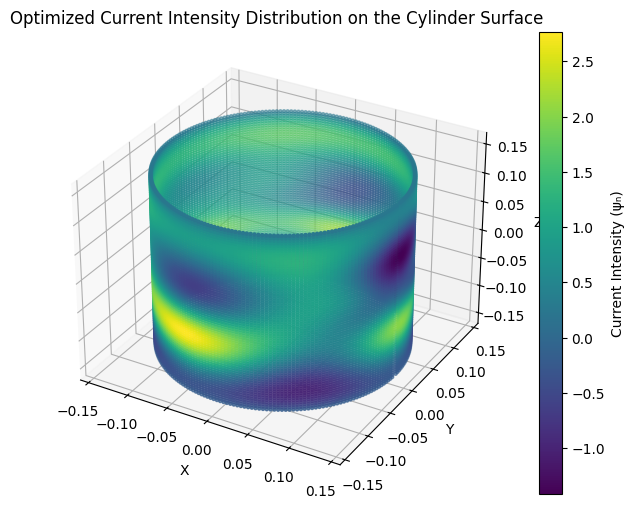

In [9]:
optimized_psi_n = psi_lambda
# 获取圆柱表面上网格点的坐标
x_coords = grid_points[:, 0]
y_coords = grid_points[:, 1]
z_coords = grid_points[:, 2]

# 可视化：使用 3D 图绘制电流强度在圆柱表面上的分布
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图：每个点的大小或颜色由电流强度决定
sc = ax.scatter(x_coords, y_coords, z_coords, c=optimized_psi_n, s=5, marker='o', cmap='viridis')

# 设置图表标题和标签
ax.set_title("Optimized Current Intensity Distribution on the Cylinder Surface")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# 添加颜色条，表示电流强度的范围
fig.colorbar(sc, label="Current Intensity (ψₙ)")

# # 如果需要显示每个点的电流强度值，可以通过 `ax.text()` 添加
# for i in range(len(grid_points)):
#     ax.text(x_coords[i], y_coords[i], z_coords[i], f'{optimized_psi_n[i]:.2f}', color='black', fontsize=8)

plt.show()

In [10]:
eta = 100 * (1 - np.std(b_k-C @ psi_lambda.squeeze()) / np.std(b_k))
print(eta)

34.106256660451905


In [11]:
import numpy as np

# 保存 psi_lambda
# np.save("psi_lambda.npy", psi_lambda)

# 加载 psi_lambda（下次使用）
psi_lambda = np.load("psi_lambda.npy")

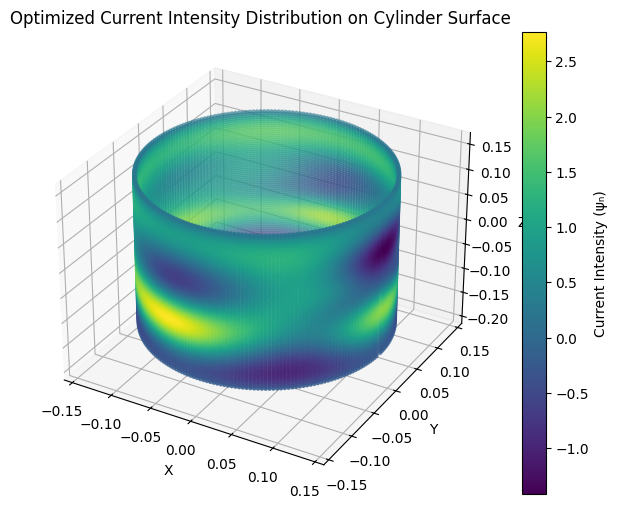

In [12]:
# 获取圆柱表面上网格点的坐标
x_coords = grid_points[:, 0]
y_coords = grid_points[:, 1]
z_coords = grid_points[:, 2]

# 创建 3D 图
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图（电流分布）
sc = ax.scatter(x_coords, y_coords, z_coords, c=optimized_psi_n, s=5, marker='o', cmap='viridis')

# 添加颜色条
fig.colorbar(sc, label="Current Intensity (ψₙ)")

# 将 x 和 y 坐标转换为网格，并将 z（电流值）插值到这个网格
x_grid, y_grid = np.meshgrid(np.unique(x_coords), np.unique(y_coords))

# 假设我们需要将电流分布映射到网格上，可以使用插值方法（如 griddata）
from scipy.interpolate import griddata

# 使用 griddata 进行插值，将 1D 数据转换为 2D
z_grid = griddata((x_coords, y_coords), optimized_psi_n, (x_grid, y_grid), method='linear')

# 绘制等值面
ax.contour3D(x_grid, y_grid, z_grid, 10, cmap='jet')

# 设置图表标题和坐标轴
ax.set_title("Optimized Current Intensity Distribution on Cylinder Surface")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

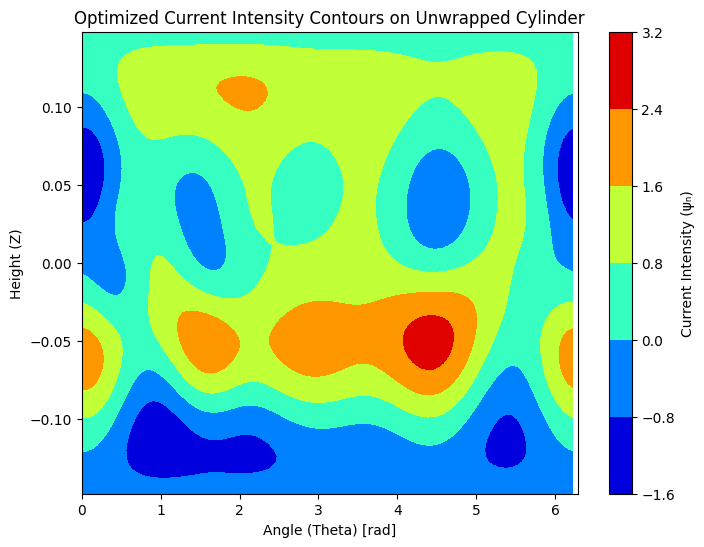

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 获取圆柱表面上网格点的坐标
x_coords = grid_points[:, 0]
y_coords = grid_points[:, 1]
z_coords = grid_points[:, 2]

# 将圆柱面展开为2D：计算角度 theta 和半径 r
r = np.sqrt(x_coords**2 + y_coords**2)  # 半径
theta = np.arctan2(y_coords, x_coords)  # 角度

# 将角度 theta 映射到 [0, 2*pi] 范围，确保展开图的横坐标是连续的
theta = np.mod(theta, 2 * np.pi)

# 创建 2D 网格
theta_grid, z_grid = np.meshgrid(np.linspace(0, 2 * np.pi, 100), np.unique(z_coords))

# 使用 griddata 插值，将优化的电流强度数据映射到展开后的网格
r_grid = griddata((theta, z_coords), r, (theta_grid, z_grid), method='linear')
psi_n_grid = griddata((theta, z_coords), optimized_psi_n, (theta_grid, z_grid), method='linear')

# 绘制展开后的2D等值线
plt.figure(figsize=(8, 6))
cp = plt.contourf(theta_grid, z_grid, psi_n_grid, 5, cmap='jet')
plt.colorbar(cp, label="Current Intensity (ψₙ)")
plt.title("Optimized Current Intensity Contours on Unwrapped Cylinder")
plt.xlabel("Angle (Theta) [rad]")
plt.ylabel("Height (Z)")

plt.show()


Contour 1, Segment 1 has 0 points.
[]
Contour 2, Segment 1 has 4 points.
[[0.         0.06109174]
 [0.04536072 0.06      ]
 [0.03141561 0.056     ]
 [0.         0.05528149]]
Contour 3, Segment 1 has 12 points.
[[6.21971879 0.04312611]
 [6.20960622 0.044     ]
 [6.17270286 0.048     ]
 [6.15625227 0.0505127 ]
 [6.15003971 0.052     ]
 [6.14052414 0.056     ]
 [6.13878994 0.06      ]
 [6.14550914 0.064     ]
 [6.15625227 0.06671778]
 [6.16448102 0.068     ]
 [6.20581875 0.072     ]
 [6.21971879 0.07297174]]
Contour 3, Segment 2 has 14 points.
[[0.         0.07423929]
 [0.06346652 0.07385727]
 [0.10015821 0.072     ]
 [0.12693304 0.07017119]
 [0.14421367 0.068     ]
 [0.16398939 0.064     ]
 [0.17205288 0.06      ]
 [0.16943621 0.056     ]
 [0.15721066 0.052     ]
 [0.13637164 0.048     ]
 [0.12693304 0.04667162]
 [0.09347625 0.044     ]
 [0.06346652 0.04205956]
 [0.         0.04153674]]
Contour 3, Segment 3 has 27 points.
[[ 0.88853126 -0.12618737]
 [ 0.82598928 -0.124     ]
 [ 0.8250647

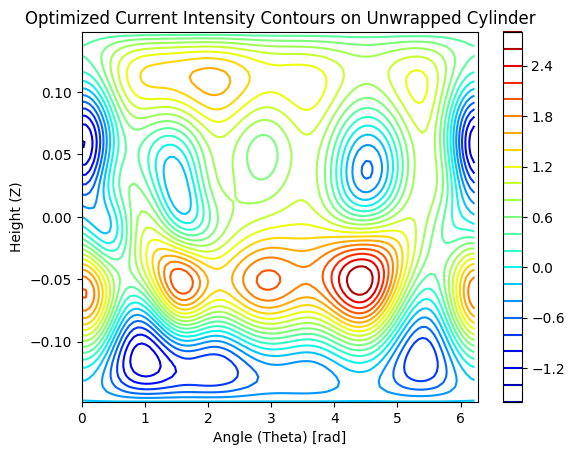

In [14]:
import numpy as np
import matplotlib.pyplot as plt

contours = plt.contour(theta_grid, z_grid, psi_n_grid, levels=20, cmap='jet')

for i, seg in enumerate(contours.allsegs):
    for j, path in enumerate(seg):
        print(f"Contour {i+1}, Segment {j+1} has {len(path)} points.")
        print(path)

plt.colorbar(contours)
plt.title("Optimized Current Intensity Contours on Unwrapped Cylinder")
plt.xlabel("Angle (Theta) [rad]")
plt.ylabel("Height (Z)")
plt.show()


Contour 1, Segment 1 has 0 points.
[]
Contour 2, Segment 1 has 7 points.
[[ 0.03173326  0.05451308]
 [-0.00232496  0.056     ]
 [-0.0087908   0.06      ]
 [ 0.03173326  0.06195967]
 [ 0.04742188  0.06      ]
 [ 0.04466297  0.056     ]
 [ 0.03173326  0.05451308]]
Contour 3, Segment 1 has 19 points.
[[ 0.92026451 -0.12175734]
 [ 0.8811614  -0.12      ]
 [ 0.856798   -0.117439  ]
 [ 0.84889198 -0.116     ]
 [ 0.85293236 -0.112     ]
 [ 0.856798   -0.11142191]
 [ 0.89775171 -0.108     ]
 [ 0.92026451 -0.10699825]
 [ 0.98373103 -0.10661608]
 [ 1.04196982 -0.108     ]
 [ 1.04719755 -0.10818162]
 [ 1.11061268 -0.112     ]
 [ 1.11066407 -0.11200615]
 [ 1.13794151 -0.116     ]
 [ 1.12721962 -0.12      ]
 [ 1.11066407 -0.12094519]
 [ 1.04719755 -0.12276235]
 [ 0.98373103 -0.12297295]
 [ 0.92026451 -0.12175734]]
Contour 3, Segment 2 has 21 points.
[[-0.03173326  0.04731138]
 [-0.04232129  0.048     ]
 [-0.08590108  0.052     ]
 [-0.09519978  0.05356026]
 [-0.10207447  0.056     ]
 [-0.10350369  0

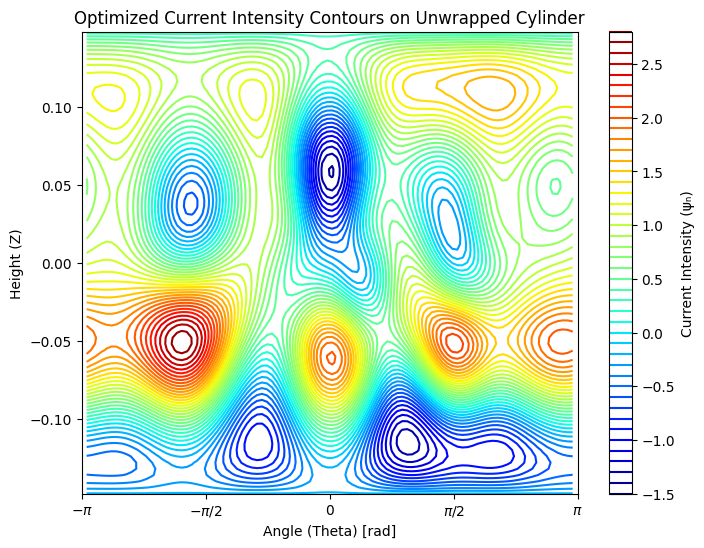

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 获取圆柱表面上网格点的坐标
x_coords = grid_points[:, 0]
y_coords = grid_points[:, 1]
z_coords = grid_points[:, 2]

# 计算角度 theta，范围设为 [-π, π]
theta = np.arctan2(y_coords, x_coords)  # [-π, π]

# 创建 2D 网格
theta_grid, z_grid = np.meshgrid(np.linspace(-np.pi, np.pi, 100), np.unique(z_coords))

# 使用 griddata 插值，将优化的电流强度数据映射到展开后的网格
r_grid = griddata((theta, z_coords), r, (theta_grid, z_grid), method='linear')
psi_n_grid = griddata((theta, z_coords), optimized_psi_n, (theta_grid, z_grid), method='linear')

# 绘制展开后的2D等值线
plt.figure(figsize=(8, 6))
cp = plt.contour(theta_grid, z_grid, psi_n_grid, 50, cmap='jet')

for i, seg in enumerate(cp.allsegs):
    for j, path in enumerate(seg):
        print(f"Contour {i+1}, Segment {j+1} has {len(path)} points.")
        print(path)

plt.colorbar(cp, label="Current Intensity (ψₙ)")
plt.title("Optimized Current Intensity Contours on Unwrapped Cylinder")
plt.xlabel("Angle (Theta) [rad]")
plt.ylabel("Height (Z)")
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels=[r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])

plt.show()


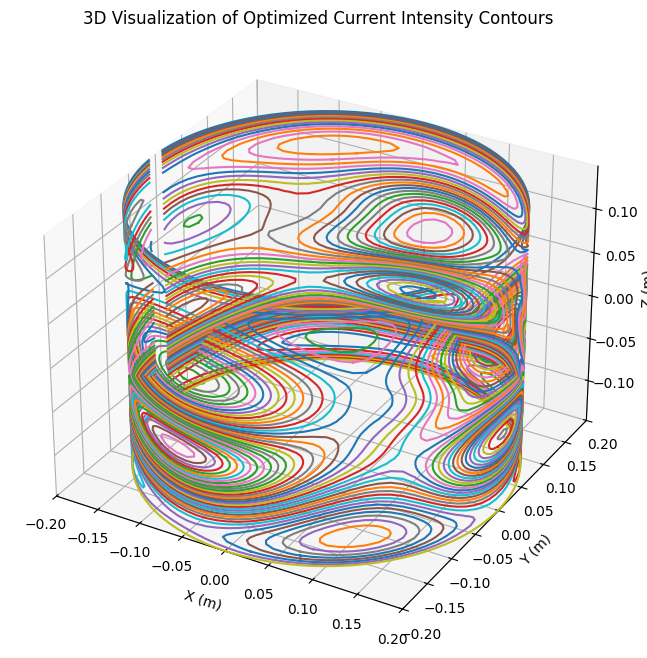

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.io import savemat
x_coords = grid_points[:, 0]
y_coords = grid_points[:, 1]
z_coords = grid_points[:, 2]

theta = np.arctan2(y_coords, x_coords)  # [-π, π]

# 创建 2D 网格
theta_grid, z_grid = np.meshgrid(np.linspace(-np.pi, np.pi, 100), np.unique(z_coords))

r_grid = griddata((theta, z_coords), r, (theta_grid, z_grid), method='linear')
psi_n_grid = griddata((theta, z_coords), optimized_psi_n, (theta_grid, z_grid), method='linear')

radius = 0.14 
scaling_factor = 0.2 / radius 

contour_3d_coords = []

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, seg in enumerate(cp.allsegs):
    for j, path in enumerate(seg):
        theta_vals = path[:, 0]
        z_vals = path[:, 1]      

        x_vals = radius * np.cos(theta_vals) * scaling_factor
        y_vals = radius * np.sin(theta_vals) * scaling_factor

        contour_3d_coords.append(np.column_stack((x_vals, y_vals, z_vals)))

        ax.plot(x_vals, y_vals, z_vals, label=f'Contour {i+1}, Segment {j+1}')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Visualization of Optimized Current Intensity Contours')

ax.set_xlim([-0.2, 0.2])
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([np.min(z_coords), np.max(z_coords)])
# 保存三维坐标为.mat文件
contour_3d_coords = np.array(contour_3d_coords, dtype=object) 

savemat('contour_3d_coords.mat', {'contour_3d_coords': contour_3d_coords})


plt.show()


15.061305915056465 9.92445826325148
0.3312901570854871 -0.4350442668562686


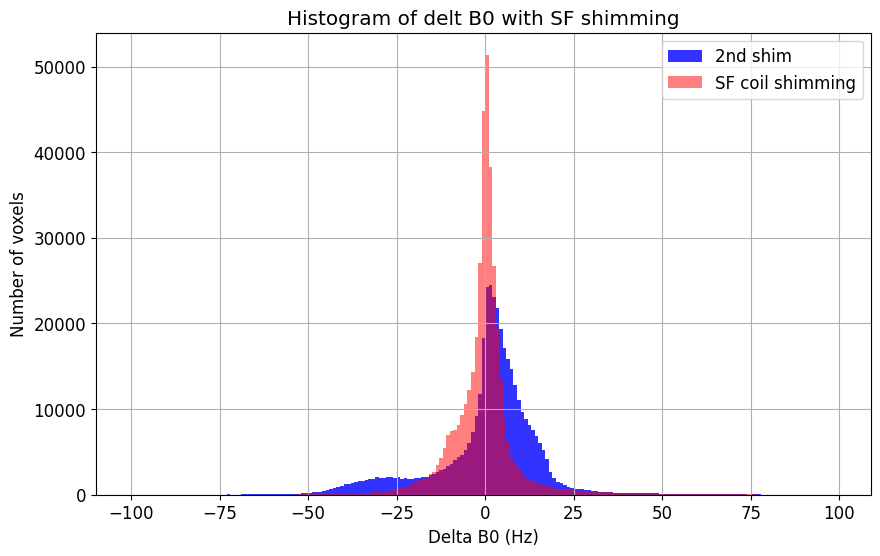

In [ ]:

unshimmed_data = b_k / 5 * 1e6 * 42.58
unshimmed_data_nan = np.where(unshimmed_data == 0, np.nan, unshimmed_data)
unshimmed_values = unshimmed_data_nan[~np.isnan(unshimmed_data_nan)] 


shimmed_data = C@optimized_psi_n / 5 * 1e6 * 42.58
shimmed_data_nan = np.where(shimmed_data == 0, np.nan, shimmed_data)
shimmed_values = shimmed_data_nan[~np.isnan(shimmed_data_nan)]
shimmed_values = unshimmed_values - shimmed_values
print(np.std(unshimmed_values), np.std(shimmed_values))
print(np.mean(unshimmed_values), np.mean(shimmed_values))
plt.figure(figsize=(10, 6),dpi = 100)
plt.hist(unshimmed_values.flatten(), bins=np.arange(-100, 100, 1), color='blue', alpha=0.8, label='2nd shim')
plt.hist(shimmed_values.flatten(), bins=np.arange(-100, 100, 1), color='red', alpha=0.5, label='SF coil shimming')
# plt.hist(values_coil_shimming.flatten(), bins=np.arange(-2, 2.05, 0.02), color='red', alpha=0.4, label='coil_shimming')
plt.rcParams.update({'font.size': 12})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Histogram of delt B0 with SF shimming')
plt.xlabel('Delta B0 (Hz)')
plt.ylabel('Number of voxels')
plt.legend()
plt.grid(True)
plt.show()
